# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [2]:
import os
os.getcwd()

'/Users/xicheng/Dropbox/Crackcode/cs231n/winter1516_assignment1/assignment1'

In [10]:
import mynotebook

ImportError: No module named mynotebook

In [11]:
import sys
sys.path.append('/Users/xicheng/Dropbox/Crackcode/cs231n/winter1516_assignment1/assignment1/cs231n')

print sys.path

"""
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
"""




['', '/Library/Python/2.7/site-packages/MySQL_python-1.2.5-py2.7-macosx-10.11-intel.egg', '/Library/Python/2.7/site-packages/redis-2.10.5-py2.7.egg', '/Library/Python/2.7/site-packages/tweepy-3.5.0-py2.7.egg', '/Library/Python/2.7/site-packages/requests_oauthlib-0.6.1-py2.7.egg', '/Library/Python/2.7/site-packages/oauthlib-1.0.3-py2.7.egg', '/Library/Python/2.7/site-packages/networkx-1.11-py2.7.egg', '/Library/Python/2.7/site-packages/pandas-0.18.1-py2.7-macosx-10.11-intel.egg', '/Library/Python/2.7/site-packages/lctool-0.1.0.dev-py2.7.egg', '/Library/Python/2.7/site-packages/six-1.10.0-py2.7.egg', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/pl

"\nmodule_path = os.path.abspath(os.path.join('..'))\nif module_path not in sys.path:\n    sys.path.append(module_path)\n    \n"

In [9]:
import cPickle as pickle
import numpy as np
import os
from scipy.misc import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def load_tiny_imagenet(path, dtype=np.float32):
  """
  Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
  TinyImageNet-200 have the same directory structure, so this can be used
  to load any of them.

  Inputs:
  - path: String giving path to the directory to load.
  - dtype: numpy datatype used to load the data.

  Returns: A tuple of
  - class_names: A list where class_names[i] is a list of strings giving the
    WordNet names for class i in the loaded dataset.
  - X_train: (N_tr, 3, 64, 64) array of training images
  - y_train: (N_tr,) array of training labels
  - X_val: (N_val, 3, 64, 64) array of validation images
  - y_val: (N_val,) array of validation labels
  - X_test: (N_test, 3, 64, 64) array of testing images.
  - y_test: (N_test,) array of test labels; if test labels are not available
    (such as in student code) then y_test will be None.
  """
  # First load wnids
  with open(os.path.join(path, 'wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

  # Map wnids to integer labels
  wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

  # Use words.txt to get names for each class
  with open(os.path.join(path, 'words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.iteritems():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
  class_names = [wnid_to_words[wnid] for wnid in wnids]

  # Next load training data.
  X_train = []
  y_train = []
  for i, wnid in enumerate(wnids):
    if (i + 1) % 20 == 0:
      print 'loading training data for synset %d / %d' % (i + 1, len(wnids))
    # To figure out the filenames we need to open the boxes file
    boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
      filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
      img_file = os.path.join(path, 'train', wnid, 'images', img_file)
      img = imread(img_file)
      if img.ndim == 2:
        ## grayscale file
        img.shape = (64, 64, 1)
      X_train_block[j] = img.transpose(2, 0, 1)
    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
  # We need to concatenate all training data
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  
  # Next load validation data
  with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
      img_file, wnid = line.split('\t')[:2]
      img_files.append(img_file)
      val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
    for i, img_file in enumerate(img_files):
      img_file = os.path.join(path, 'val', 'images', img_file)
      img = imread(img_file)
      if img.ndim == 2:
        img.shape = (64, 64, 1)
      X_val[i] = img.transpose(2, 0, 1)

  # Next load test images
  # Students won't have test labels, so we need to iterate over files in the
  # images directory.
  img_files = os.listdir(os.path.join(path, 'test', 'images'))
  X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
  for i, img_file in enumerate(img_files):
    img_file = os.path.join(path, 'test', 'images', img_file)
    img = imread(img_file)
    if img.ndim == 2:
      img.shape = (64, 64, 1)
    X_test[i] = img.transpose(2, 0, 1)

  y_test = None
  y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
  if os.path.isfile(y_test_file):
    with open(y_test_file, 'r') as f:
      img_file_to_wnid = {}
      for line in f:
        line = line.split('\t')
        img_file_to_wnid[line[0]] = line[1]
    y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
    y_test = np.array(y_test)
  
  return class_names, X_train, y_train, X_val, y_val, X_test, y_test


def load_models(models_dir):
  """
  Load saved models from disk. This will attempt to unpickle all files in a
  directory; any files that give errors on unpickling (such as README.txt) will
  be skipped.

  Inputs:
  - models_dir: String giving the path to a directory containing model files.
    Each model file is a pickled dictionary with a 'model' field.

  Returns:
  A dictionary mapping model file names to models.
  """
  models = {}
  for model_file in os.listdir(models_dir):
    with open(os.path.join(models_dir, model_file), 'rb') as f:
      try:
        models[model_file] = pickle.load(f)['model']
      except pickle.UnpicklingError:
        continue
  return models


In [7]:
# Run some setup code for this notebook.

import random
import numpy as np
#sys.path.append('/Users/xicheng/Dropbox/Crackcode/cs231n/winter1516_assignment1/assignment1/cs231n/data_utils.py')

#import cs231n
#from cs231n.data_utils import load_CIFAR10


#import load_CIFAR10

import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [12]:
# Load the raw CIFAR-10 data.
cifar10_dir = '/Users/xicheng/Dropbox/Crackcode/cs231n/winter1516_assignment1/assignment1/cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


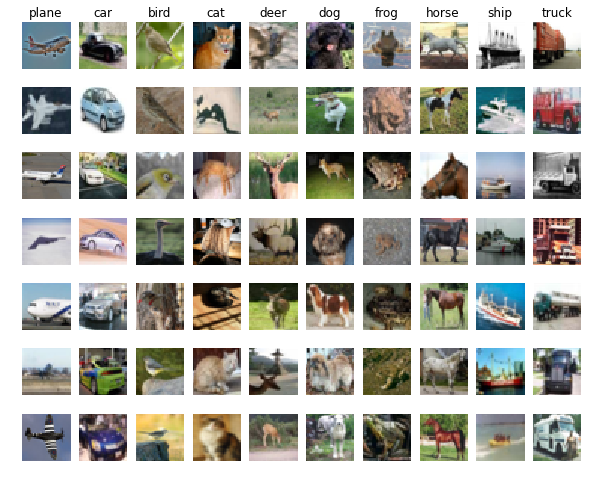

In [13]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [15]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [16]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(5000, 3072) (500, 3072)


In [57]:
import numpy as np
from collections import Counter

class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
      for j in xrange(num_train):
        #####################################################################
        # TODO:                                                             #
        # Compute the l2 distance between the ith test point and the jth    #
        # training point, and store the result in dists[i, j]. You should   #
        # not use a loop over dimension.                                    #
        #####################################################################
        dists[i,j] = np.sqrt(np.sum(np.square(X[i,:]-self.X_train[j,:])))
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
      #######################################################################
      # TODO:                                                               #
      # Compute the l2 distance between the ith test point and all training #
      # points, and store the result in dists[i, :].                        #
      #######################################################################
      dists[i,:] = np.sqrt(np.sum(np.square(X[i,:] - self.X_train), axis=1))
      #######################################################################
      #                         END OF YOUR CODE                            #
      #######################################################################
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    #########################################################################
    # TODO:                                                                 #
    # Compute the l2 distance between all test points and all training      #
    # points without using any explicit loops, and store the result in      #
    # dists.                                                                #
    #                                                                       #
    # You should implement this function using only basic array operations; #
    # in particular you should not use functions from scipy.                #
    #                                                                       #
    # HINT: Try to formulate the l2 distance using matrix multiplication    #
    #       and two broadcast sums.                                         #
    #########################################################################
    M = np.dot(X, self.X_train.T)
    te = np.square(X).sum(axis=1)
    tr = np.square(self.X_train).sum(axis=1)
    dists = np.sqrt(-2*M + np.matrix(tr) + np.matrix(te).T)
    #########################################################################
    #                         END OF YOUR CODE                              #
    #########################################################################
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in xrange(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.
      closest_y = []
      #########################################################################
      # TODO:                                                                 #
      # Use the distance matrix to find the k nearest neighbors of the ith    #
      # testing point, and use self.y_train to find the labels of these       #
      # neighbors. Store these labels in closest_y.                           #
      # Hint: Look up the function numpy.argsort.                             #
      #########################################################################
      y_indicies = np.argsort(dists[i, :], axis = 0)
      closest_y = self.y_train[y_indicies[:k]]
        
      print closest_y.shape #(1, 5000)
      test_closest_y = np.reshape(closest_y, 5000)
      print test_closest_y.shape
    
      #########################################################################
      # TODO:                                                                 #
      # Now that you have found the labels of the k nearest neighbors, you    #
      # need to find the most common label in the list closest_y of labels.   #
      # Store this label in y_pred[i]. Break ties by choosing the smaller     #
      # label.                                                                #
      #########################################################################
      
      #c = Counter(closest_y)
      #y_pred[i] = c.most_common(1)[0][0]

      #########################################################################
      #                           END OF YOUR CODE                            # 
      #########################################################################

    return y_pred



In [51]:
#from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [29]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print dists.shape

(500, 5000)


In [30]:
print dists

[[ 3803.92350081  4210.59603857  5504.0544147  ...,  4007.64756434
   4203.28086142  4354.20256764]
 [ 6336.83367306  5270.28006846  4040.63608854 ...,  4829.15334194
   4694.09767687  7768.33347636]
 [ 5224.83913628  4250.64289255  3773.94581307 ...,  3766.81549853
   4464.99921613  6353.57190878]
 ..., 
 [ 5366.93534524  5062.8772452   6361.85774755 ...,  5126.56824786
   4537.30613911  5920.94156364]
 [ 3671.92919322  3858.60765044  4846.88157479 ...,  3521.04515734
   3182.3673578   4448.65305458]
 [ 6960.92443573  6083.71366848  6338.13442584 ...,  6083.55504619
   4128.24744898  8041.05223214]]


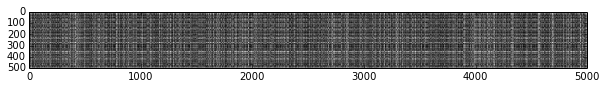

In [31]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



In [53]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

(1, 4000)


TypeError: unhashable type: 'numpy.ndarray'

In [33]:
print dists.shape, y_test_pred.shape

(500, 5000) (500,)


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [54]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

(1, 4000)


TypeError: unhashable type: 'numpy.ndarray'

In [60]:
print dists.shape, y_test_pred.shape

(500, 4000) (500,)


You should expect to see a slightly better performance than with `k = 1`.

In [35]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [36]:
print X_test.shape, dists_one.shape, dists.shape

(500, 3072) (500, 5000) (500, 5000)


In [37]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


In [38]:
print X_test.shape, dists_two.shape, dists.shape, 

(500, 3072) (500, 5000) (500, 5000)


In [39]:
dists_no_loops = classifier.compute_distances_no_loops(X_test)
print dists_no_loops.shape

(500, 5000)


In [55]:
#k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
y_test_pred_one_loops = classifier.predict_labels(dists_one, k=3)

print y_test_pred_one_loops.shape

(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)
(3,)


In [41]:
print dists_one

[[ 3803.92350081  4210.59603857  5504.0544147  ...,  4007.64756434
   4203.28086142  4354.20256764]
 [ 6336.83367306  5270.28006846  4040.63608854 ...,  4829.15334194
   4694.09767687  7768.33347636]
 [ 5224.83913628  4250.64289255  3773.94581307 ...,  3766.81549853
   4464.99921613  6353.57190878]
 ..., 
 [ 5366.93534524  5062.8772452   6361.85774755 ...,  5126.56824786
   4537.30613911  5920.94156364]
 [ 3671.92919322  3858.60765044  4846.88157479 ...,  3521.04515734
   3182.3673578   4448.65305458]
 [ 6960.92443573  6083.71366848  6338.13442584 ...,  6083.55504619
   4128.24744898  8041.05223214]]


In [78]:
print y_test_pred_one_loops

[ 4.  8.  8.  0.  4.  2.  2.  2.  2.  8.  0.  4.  3.  6.  8.  2.  2.  3.
  1.  2.  2.  0.  0.  4.  2.  4.  6.  2.  2.  3.  6.  2.  2.  3.  8.  1.
  2.  8.  2.  2.  8.  6.  2.  4.  0.  0.  5.  8.  4.  2.  0.  8.  4.  2.
  8.  8.  4.  0.  0.  2.  3.  6.  6.  3.  4.  2.  1.  0.  3.  1.  2.  4.
  8.  8.  0.  4.  2.  3.  6.  8.  8.  6.  6.  0.  2.  4.  2.  8.  8.  8.
  0.  2.  8.  1.  4.  0.  4.  0.  0.  0.  4.  4.  3.  3.  4.  8.  6.  6.
  5.  5.  2.  0.  6.  4.  7.  4.  2.  4.  4.  4.  8.  4.  2.  6.  8.  4.
  0.  2.  4.  2.  2.  1.  0.  3.  6.  2.  9.  0.  2.  8.  0.  0.  4.  5.
  8.  2.  2.  5.  3.  8.  0.  3.  2.  2.  4.  4.  0.  8.  5.  0.  0.  4.
  3.  2.  0.  0.  8.  2.  5.  0.  8.  7.  0.  8.  4.  1.  0.  2.  6.  0.
  8.  4.  2.  0.  5.  0.  6.  2.  0.  8.  3.  4.  2.  3.  6.  3.  8.  0.
  3.  2.  3.  0.  8.  3.  2.  4.  0.  2.  2.  0.  2.  8.  2.  4.  8.  0.
  0.  1.  0.  4.  4.  3.  2.  0.  3.  4.  1.  2.  4.  4.  3.  1.  2.  3.
  0.  0.  2.  9.  0.  0.  0.  0.  2.  0.  0.  2.  6

In [44]:
print dists_no_loops

[[ 3803.92350081  4210.59603857  5504.0544147  ...,  4007.64756434
   4203.28086142  4354.20256764]
 [ 6336.83367306  5270.28006846  4040.63608854 ...,  4829.15334194
   4694.09767687  7768.33347636]
 [ 5224.83913628  4250.64289255  3773.94581307 ...,  3766.81549853
   4464.99921613  6353.57190878]
 ..., 
 [ 5366.93534524  5062.8772452   6361.85774755 ...,  5126.56824786
   4537.30613911  5920.94156364]
 [ 3671.92919322  3858.60765044  4846.88157479 ...,  3521.04515734
   3182.3673578   4448.65305458]
 [ 6960.92443573  6083.71366848  6338.13442584 ...,  6083.55504619
   4128.24744898  8041.05223214]]


In [56]:
y_test_pred_no_loops = classifier.predict_labels(dists_no_loops, k=10)

print y_test_pred_no_loops.shape

(1, 5000)


TypeError: unhashable type: 'numpy.ndarray'

In [47]:
#k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
y_test_pred_no_loops = classifier.predict_labels(dists_no_loops, k=1)

print y_test_pred_no_loops.shape

TypeError: unhashable type: 'numpy.ndarray'

In [48]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print 'No loop version took %f seconds' % no_loop_time

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 55.924625 seconds
One loop version took 66.765994 seconds
No loop version took 0.592944 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [49]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for k in k_choices:
    k_to_accuracies[k] = []
    # Run kNN algorithm num_folds times
    for i in range(num_folds):
        # Concatenate arrays
        X_train_new = []
        y_train_new = []
        for j in range(num_folds):
            if i != j:
                X_train_new.extend(X_train_folds[j])
                y_train_new.extend(y_train_folds[j])

        X_train_new = np.array(X_train_new)
        y_train_new = np.array(y_train_new)
        classifier = KNearestNeighbor()
        classifier.train(X_train_new, y_train_new)
        dists = classifier.compute_distances_no_loops(X_test)
        #print dists.shape
        
        y_test_pred = classifier.predict_labels(dists, k=k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
        
        k_to_accuracies[k].append(accuracy)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)